In [62]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.cluster import KMeans
sys.path.append("../scripts")
from utils import Utils
from clean_data import DataCleaner

cleaner = DataCleaner()
utility = Utils()

In [63]:
cleaned_df=utility.load_data("../data/cleaned_data.csv")
# since our csv file doesn't have a meta data of columns dtype, we manually convert ['bearer_id', 'imsi', 'msisdn/number', 'imei','handset_type'] to string once again
cleaned_df=cleaner.convert_to_string(cleaned_df)

In [64]:
cleaned_df.rename(columns={"msisdn/number":"msisdn"},inplace=True)
cleaned_df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'tcp_dl_retrans._vol_(bytes)', 'tcp_ul_retrans._vol_(bytes)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'http_dl_(bytes)', 'http_ul_(bytes)', 'activity_duration_dl_(ms)',
       'activity_duration_ul_(ms)', 'dur._(ms).1', 'handset_manufacturer',
       'handset_type', 'nb_of_sec_with_125000b_<_vol_dl',
       'nb_of_sec_with_1250b_<_vol_ul_<_6250b',
       'nb_of_sec_with_31250b_<_vol_dl_<_125000b',
       'nb_of_sec_with_37500b_<_vol_ul',
       'nb_of_sec_with_6250b_<_vol_dl_<_31250b',
       'nb_of_sec_with_6250b_<_vol_ul_<_37500b',
       

In [65]:
user_experience_df = cleaned_df[['msisdn', 'handset_type','avg_rtt_dl_(ms)','avg_rtt_ul_(ms)','avg_bearer_tp_dl_(kbps)','avg_bearer_tp_ul_(kbps)','tcp_dl_retrans._vol_(bytes)','tcp_ul_retrans._vol_(bytes)']]
user_experience_df.head()

,msisdn,handset_type,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes)
0,33664962239.0,Samsung Galaxy A5 Sm-A520F,42.0,5.0,23.0,44.0,568730.0,20949.5
1,33681854413.0,Samsung Galaxy J5 (Sm-J530),65.0,5.0,16.0,26.0,568730.0,20949.5
2,33760627129.0,Samsung Galaxy A8 (2018),45.0,5.0,6.0,9.0,568730.0,20949.5
3,33750343200.0,undefined,45.0,5.0,44.0,44.0,568730.0,20949.5
4,33699795932.0,Samsung Sm-G390F,45.0,5.0,6.0,9.0,568730.0,20949.5


In [109]:
total_rtt=user_experience_df['avg_rtt_dl_(ms)']+user_experience_df['avg_rtt_ul_(ms)']
total_tp=user_experience_df['avg_bearer_tp_dl_(kbps)']+user_experience_df['avg_bearer_tp_ul_(kbps)']
total_tcp=user_experience_df['tcp_dl_retrans._vol_(bytes)']+user_experience_df['tcp_ul_retrans._vol_(bytes)']
user_experience_total=pd.DataFrame({"msisdn":user_experience_df['msisdn'],"handset_type":user_experience_df['handset_type'],"total_rtt(ms)":total_rtt,"total_tp(kbps)":total_tp,"total_tcp(bytes)":total_tcp})
user_experience_total2=user_experience_total.copy()
user_experience_total.head()


,msisdn,handset_type,total_rtt(ms),total_tp(kbps),total_tcp(bytes)
0,33664962239.0,Samsung Galaxy A5 Sm-A520F,47.0,67.0,589679.5
1,33681854413.0,Samsung Galaxy J5 (Sm-J530),70.0,42.0,589679.5
2,33760627129.0,Samsung Galaxy A8 (2018),50.0,15.0,589679.5
3,33750343200.0,undefined,50.0,88.0,589679.5
4,33699795932.0,Samsung Sm-G390F,50.0,15.0,589679.5


### Aggregate, per customer, the following information 
- Average TCP retransmission
- Average RTT
- Handset type
- Average throughput


In [67]:
customer_group=user_experience_total.groupby(['msisdn'])

avg_tcp_retran=customer_group.agg({'total_tcp(bytes)':'mean'})
avg_tcp_retran.rename(columns={'total_tcp(bytes)':'avg_tcp(bytes)'},inplace=True)
avg_tcp_retran

,avg_tcp(bytes)
msisdn,
3197020876596.0,5.896795e+05
33601001722.0,5.896795e+05
33601001754.0,5.896795e+05
33601002511.0,5.896795e+05
33601007832.0,2.201550e+04
...,...
33789980299.0,2.998878e+05
33789996170.0,2.180450e+05
33789997247.0,5.896795e+05


In [68]:
avg_rtt=customer_group.agg({'total_rtt(ms)':'mean'})
avg_rtt.rename(columns={'total_rtt(ms)':'avg_rtt(ms)'},inplace=True)
avg_rtt

,avg_rtt(ms)
msisdn,
3197020876596.0,50.000000
33601001722.0,46.000000
33601001754.0,31.000000
33601002511.0,50.000000
33601007832.0,84.000000
...,...
33789980299.0,59.500000
33789996170.0,52.000000
33789997247.0,40.000000


In [69]:
freq_handset=customer_group.agg({'handset_type':pd.Series.mode})
freq_handset.rename(columns={'handset_type':'freq_handset_type'},inplace=True)
freq_handset

,freq_handset_type
msisdn,
3197020876596.0,Quectel Wireless. Quectel Ec25-E
33601001722.0,Huawei P20 Lite Huawei Nova 3E
33601001754.0,Apple iPhone 7 (A1778)
33601002511.0,undefined
33601007832.0,Apple iPhone 5S (A1457)
...,...
33789980299.0,undefined
33789996170.0,Huawei Honor 9 Lite
33789997247.0,Apple iPhone 8 Plus (A1897)


In [70]:
avg_tp=customer_group.agg({'total_tp(kbps)':'mean'})
avg_tp.rename(columns={'total_tp(kbps)':'avg_tp(kbps)'},inplace=True)
avg_tp

,avg_tp(kbps)
msisdn,
3197020876596.0,1.000000
33601001722.0,76.000000
33601001754.0,99.000000
33601002511.0,97.000000
33601007832.0,248.000000
...,...
33789980299.0,81539.500000
33789996170.0,10365.000000
33789997247.0,116.000000


In [71]:
# experience_by_customer=pd.DataFrame({
#     "avg_rtt_(ms)":avg_rtt,
#     "avg_tp(kbps)":avg_tp,
#     "avg_tcp_(bytes)":avg_tcp_retran
# },index=avg_rtt.index)
experience_by_customer=avg_rtt.copy()
experience_by_customer["avg_tp(kbps)"]=avg_tp
experience_by_customer["avg_tcp(bytes)"]=avg_tcp_retran
experience_by_customer

,avg_rtt(ms),avg_tp(kbps),avg_tcp(bytes)
msisdn,,,
3197020876596.0,50.000000,1.000000,5.896795e+05
33601001722.0,46.000000,76.000000,5.896795e+05
33601001754.0,31.000000,99.000000,5.896795e+05
33601002511.0,50.000000,97.000000,5.896795e+05
33601007832.0,84.000000,248.000000,2.201550e+04
...,...,...,...
33789980299.0,59.500000,81539.500000,2.998878e+05
33789996170.0,52.000000,10365.000000,2.180450e+05
33789997247.0,40.000000,116.000000,5.896795e+05


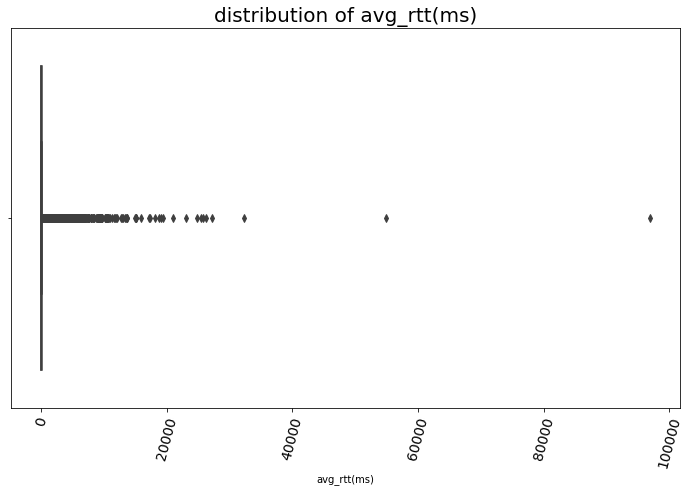

In [72]:
utility.plot_box(df=experience_by_customer,x_col="avg_rtt(ms)",title="distribution of avg_rtt(ms)")

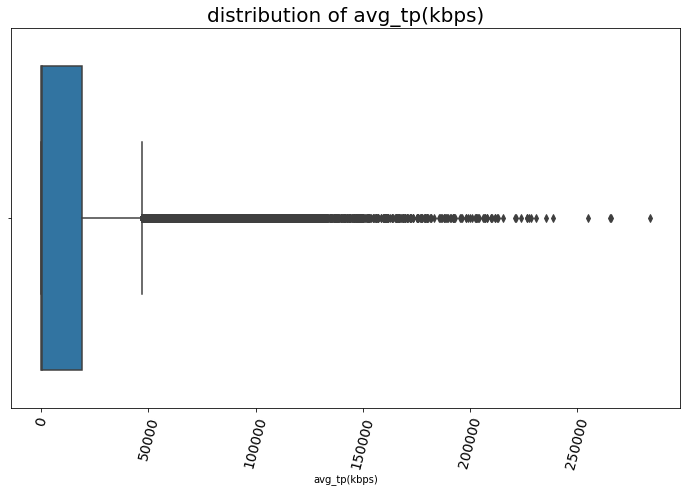

In [73]:

utility.plot_box(df=experience_by_customer,x_col="avg_tp(kbps)",title="distribution of avg_tp(kbps)")


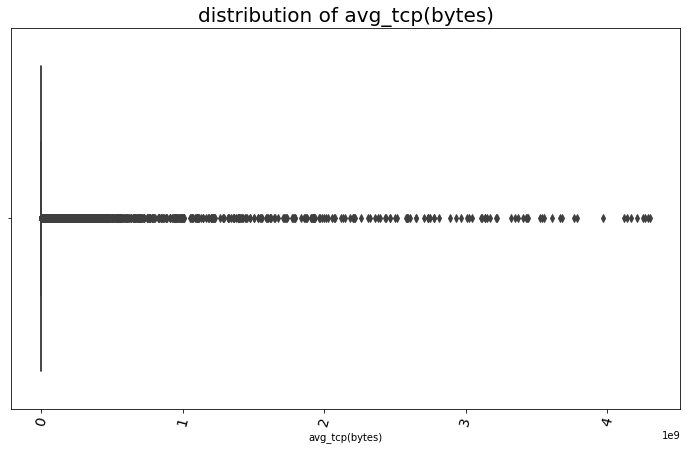

In [74]:
utility.plot_box(df=experience_by_customer,x_col="avg_tcp(bytes)",title="distribution of avg_tcp(bytes)")


In [75]:
experience_by_customer = cleaner.handle_outliers(experience_by_customer, 'avg_rtt(ms)', 'mean')
experience_by_customer = cleaner.handle_outliers(experience_by_customer, 'avg_tp(kbps)', 'mean')
experience_by_customer = cleaner.handle_outliers(experience_by_customer, 'avg_tcp(bytes)', 'mean')

experience_by_customer.head()

,avg_rtt(ms),avg_tp(kbps),avg_tcp(bytes)
msisdn,,,
3197020876596.0,50.0,1.0,589679.50
33601001722.0,46.0,76.0,589679.50
33601001754.0,31.0,99.0,589679.50
33601002511.0,50.0,97.0,589679.50
33601007832.0,84.0,248.0,556100.75


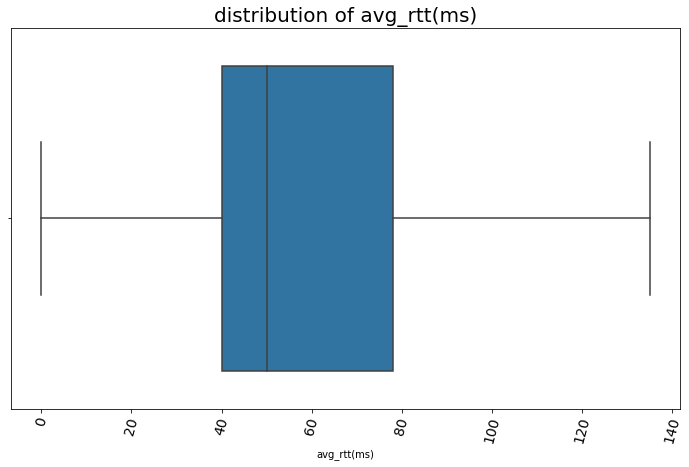

In [76]:
utility.plot_box(df=experience_by_customer,x_col="avg_rtt(ms)",title="distribution of avg_rtt(ms)")


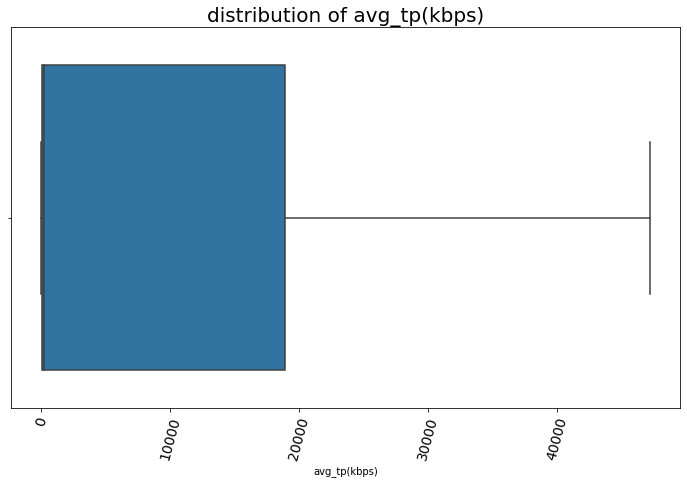

In [77]:
utility.plot_box(df=experience_by_customer,x_col="avg_tp(kbps)",title="distribution of avg_tp(kbps)")


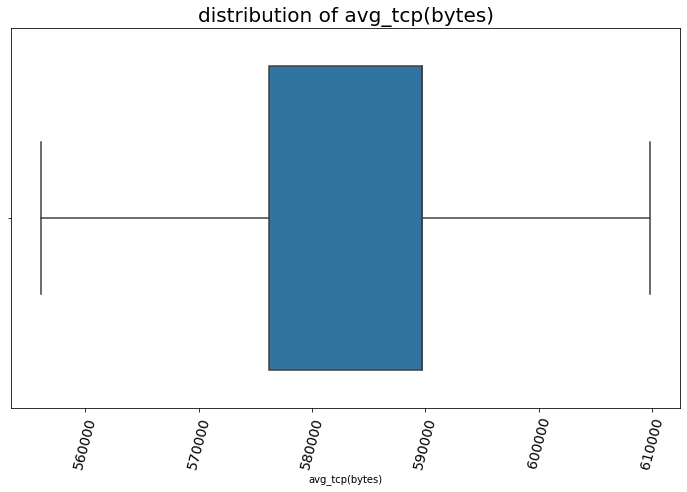

In [78]:
utility.plot_box(df=experience_by_customer,x_col="avg_tcp(bytes)",title="distribution of avg_tcp(bytes)")


### Top 10 TCP, RTT, TP values

In [116]:
print("Top 10 TCP")
top_10_tcp=avg_tcp_retran.sort_values(by=["avg_tcp(bytes)"],ascending=False).head(10)
display(top_10_tcp)

print("Top 10 RTT")
top_10_rtt=avg_rtt.sort_values(by=["avg_rtt(ms)"],ascending=False).head(10)
display(top_10_rtt)

print("Top 10 TP")
top_10_tp=avg_tp.sort_values(by=["avg_tp(kbps)"],ascending=False).head(10)
display(top_10_tp)

Top 10 TCP


,avg_tcp(bytes)
msisdn,
33698575965.0,4.301477e+09
33658706088.0,4.288121e+09
33664907178.0,4.268647e+09
33658633234.0,4.254660e+09
33666125485.0,4.211258e+09
33668768421.0,4.166595e+09
33661305358.0,4.137938e+09
33662396708.0,4.117805e+09
33666824231.0,3.968121e+09


Top 10 RTT


,avg_rtt(ms)
msisdn,
33662317023.0,96924.0
33683692867.0,54848.0
33660874265.0,32335.0
33760941100.0,27278.0
33606788933.0,26300.0
33671816754.0,25715.0
33781865588.0,25388.0
33784013667.0,24738.0
33698551167.0,23010.5


Top 10 TP


,avg_tp(kbps)
msisdn,
33659907570.0,283931.0
33662681056.0,265724.0
33665658364.0,265176.5
33663487108.0,254950.0
33627953865.0,238982.0
33621176428.0,235365.0
33782399167.0,230982.0
33651479599.0,228303.0
33760327549.0,227334.0


### Bottom 10 TCP, RTT, TP values

In [114]:
print("Bottom 10 TCP")
bottom_10_tcp=avg_tcp_retran.sort_values(by=["avg_tcp(bytes)"],ascending=False).tail(10)
display(bottom_10_tcp)

print("Bottom 10 RTT")
bottom_10_rtt=avg_rtt.sort_values(by=["avg_rtt(ms)"],ascending=False).tail(10)
display(bottom_10_rtt)

print("Bottom 10 TP")
bottom_10_tp=avg_tp.sort_values(by=["avg_tp(kbps)"],ascending=False).tail(10)
display(bottom_10_tp)

Bottom 10 TCP


,avg_tcp(bytes)
msisdn,
33699694715.0,182.0
33679366089.0,179.0
33784203839.0,177.0
33769636458.0,176.0
33650681239.0,176.0
33607833304.0,143.0
33626357513.0,134.0
33762062356.0,129.0
33614777138.0,128.0


Bottom 10 RTT


,avg_rtt(ms)
msisdn,
33634684770.0,10.0
33672196893.0,9.0
33610846366.0,9.0
33647679481.0,8.0
33668619895.0,6.0
33659493541.0,5.0
33695045499.0,4.0
33660204450.0,2.0
33661575382.0,0.0


Bottom 10 TP


,avg_tp(kbps)
msisdn,
33666206832.0,0.0
33660916790.0,0.0
33698591046.0,0.0
33659471143.0,0.0
33621664002.0,0.0
33777464744.0,0.0
33619834498.0,0.0
33650000334.0,0.0
33660339983.0,0.0


### Top 10 frequent TCP, RTT, TP values

In [81]:
print("10 top frequent TCP")
display(avg_tcp_retran.value_counts().sort_values(ascending=False).head(10))

print("10 top frequent RTT")
display(avg_rtt.value_counts().sort_values(ascending=False).head(10))

print("10 top frequent TP")
display(avg_tp.value_counts().sort_values(ascending=False).head(10))

10 top frequent TCP


avg_tcp(bytes)
589679.50         55974
570024.00           367
570060.00           167
22279.50            145
579851.75            82
570048.00            81
21041.50             78
23609.50             78
20987.50             70
571390.00            65
dtype: int64

10 top frequent RTT


avg_rtt(ms)
50.0           19546
29.0            2950
39.0            2409
38.0            1657
40.0            1642
30.0            1577
28.0            1457
49.0            1391
41.0            1260
31.0            1190
dtype: int64

10 top frequent TP


avg_tp(kbps)
15.0            2872
63.0            2138
97.0            1094
90.0            1062
98.0            1025
96.0             938
99.0             918
89.0             881
91.0             864
95.0             856
dtype: int64

- Distribution of the average throughput per handset type and provide interpretation
- Distribution of the average tcp transmission view per handset type

In [82]:
user_experience_total

,msisdn,handset_type,total_rtt(ms),total_tp(kbps),total_tcp(bytes)
0,33664962239.0,Samsung Galaxy A5 Sm-A520F,47.0,67.0,589679.5
1,33681854413.0,Samsung Galaxy J5 (Sm-J530),70.0,42.0,589679.5
2,33760627129.0,Samsung Galaxy A8 (2018),50.0,15.0,589679.5
3,33750343200.0,undefined,50.0,88.0,589679.5
4,33699795932.0,Samsung Sm-G390F,50.0,15.0,589679.5
...,...,...,...,...,...
149996,33650688697.0,Apple iPhone 8 Plus (A1897),32.0,117.0,589679.5
149997,33663449963.0,Apple iPhone Se (A1723),29.0,77.0,589679.5
149998,33621890103.0,Apple iPhone Xs (A2097),49.0,90.0,589679.5
149999,33619622058.0,Huawei Fig-Lx1,42.0,71.0,589679.5


In [99]:
avg_by_handset_type=user_experience_total.groupby('handset_type').agg({'total_tp(kbps)':'mean','total_tcp(bytes)':'mean','total_rtt(ms)':'mean'})


display(avg_by_handset_type.head())


,total_tp(kbps),total_tcp(bytes),total_rtt(ms)
handset_type,,,
A-Link Telecom I. Cubot A5,23510.0,589679.5,42.0
A-Link Telecom I. Cubot Note Plus,6699.0,616213.0,1589.0
A-Link Telecom I. Cubot Note S,8937.0,41411731.0,890.0
A-Link Telecom I. Cubot Nova,56217.0,137170.0,44.0
A-Link Telecom I. Cubot Power,69468.0,8041.0,43.0


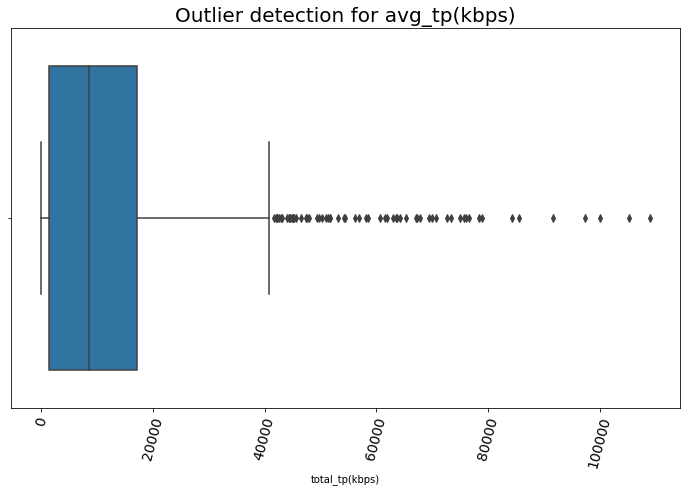

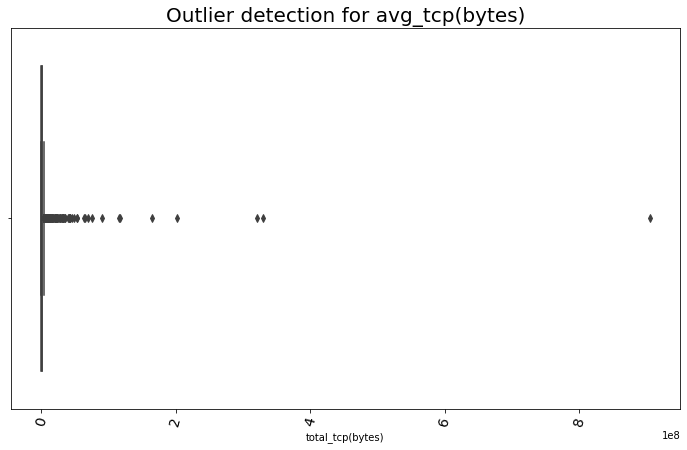

In [100]:
utility.plot_box(avg_by_handset_type,"total_tp(kbps)","Outlier detection for avg_tp(kbps)")
utility.plot_box(avg_by_handset_type,"total_tcp(bytes)","Outlier detection for avg_tcp(bytes)")

We can see that both avg_tcp and avg_tp show the presence of outliers

In [101]:
cleaned_per_handset = cleaner.handle_outliers(avg_by_handset_type, 'total_tp(kbps)')
cleaned_per_handset = cleaner.handle_outliers(cleaned_per_handset, 'total_tcp(bytes)')
cleaned_per_handset = cleaner.handle_outliers(cleaned_per_handset, 'total_rtt(ms)')

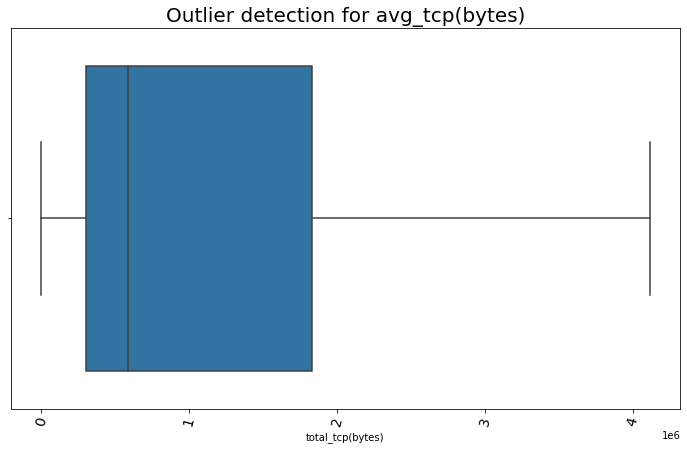

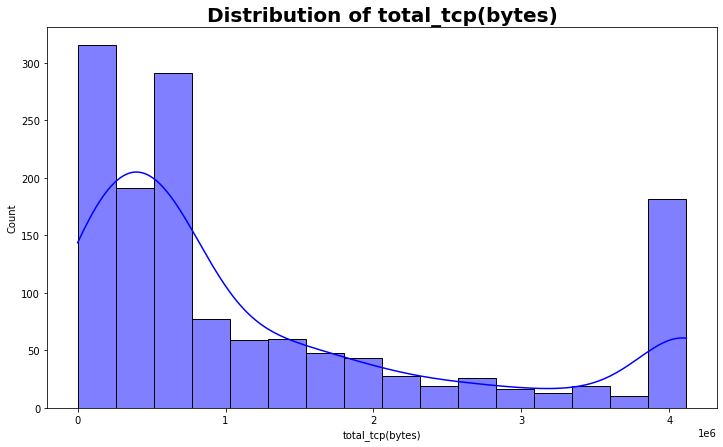

In [102]:
utility.plot_box(cleaned_per_handset, 'total_tcp(bytes)', 'Outlier detection for avg_tcp(bytes)')

utility.plot_hist(cleaned_per_handset, 'total_tcp(bytes)', 'blue')


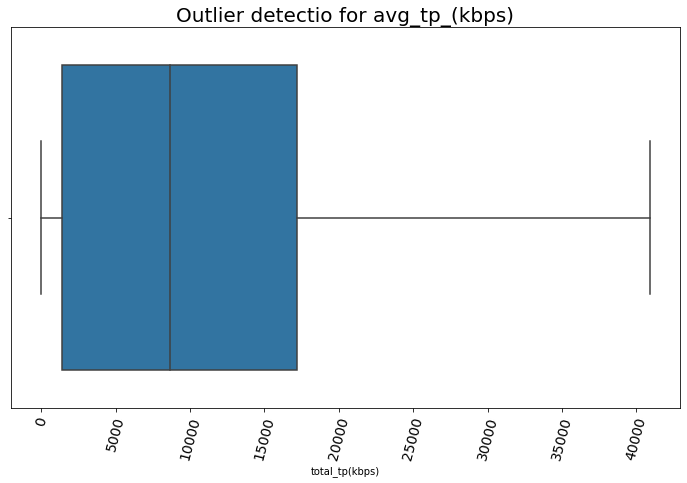

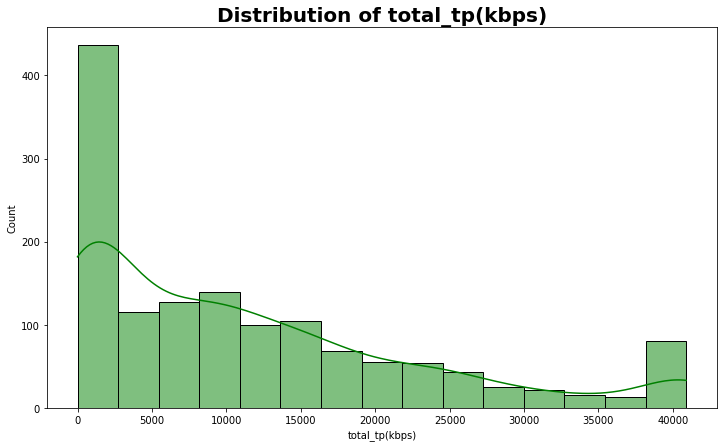

In [103]:
utility.plot_box(cleaned_per_handset, 'total_tp(kbps)', 'Outlier detectio for avg_tp_(kbps)')
utility.plot_hist(cleaned_per_handset, 'total_tp(kbps)','green')

### K-means clustering using experience metrics

In [88]:
kmeans= KMeans(
    init="k-means++",
    n_clusters= 3,
    n_init= 10,
    max_iter= 300,
    random_state=20  
)

In [104]:
normalized_experience_metric = cleaner.normalizer(user_experience_total)
normalized_experience_metric

,total_rtt(ms),total_tp(kbps),total_tcp(bytes)
0,0.000080,0.000114,1.0
1,0.000119,0.000071,1.0
2,0.000085,0.000025,1.0
3,0.000085,0.000149,1.0
4,0.000085,0.000025,1.0
...,...,...,...
149996,0.000054,0.000198,1.0
149997,0.000049,0.000131,1.0
149998,0.000083,0.000153,1.0
149999,0.000071,0.000120,1.0


In [105]:
model = kmeans.fit(normalized_experience_metric)
centroids = kmeans.cluster_centers_

In [106]:
with open("../models/user_experience_metric_clustering_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [107]:
clustered_experience = user_experience_total.copy()
clustered_experience['cluster'] = model.predict(normalized_experience_metric)
clustered_experience.head()

,msisdn,handset_type,total_rtt(ms),total_tp(kbps),total_tcp(bytes),cluster
0,33664962239.0,Samsung Galaxy A5 Sm-A520F,47.0,67.0,589679.5,1
1,33681854413.0,Samsung Galaxy J5 (Sm-J530),70.0,42.0,589679.5,1
2,33760627129.0,Samsung Galaxy A8 (2018),50.0,15.0,589679.5,1
3,33750343200.0,undefined,50.0,88.0,589679.5,1
4,33699795932.0,Samsung Sm-G390F,50.0,15.0,589679.5,1


In [97]:
clustered = clustered_experience[["total_rtt(ms)","total_tp(kbps)","total_tcp(bytes)","cluster"]].groupby('cluster').agg(['min','max','mean','count','var','std'])
clustered

total_rtt(ms)                                                          \
                  min      max        mean   count            var         std   
cluster                                                                         
0                19.0  11238.0   77.309840    7917   36629.149945  191.387434   
1                 0.0  96924.0  117.070816  137060  348059.852959  589.965976   
2                19.0   3125.0   60.857484    5024    4369.124021   66.099350   

        total_tp(kbps)                                                \
                   min       max          mean   count           var   
cluster                                                                
0                129.0  382262.0  34108.692055    7917  9.353044e+08   
1                  0.0  304299.0  12873.623807  137060  6.354708e+08   
2                251.0  313244.0  44998.789411    5024  1.077342e+09   

                      total_tcp(bytes)                                      \
                  std              min           max          mean   count   
cluster                                                                      
0        30582.746362            182.0  1.284627e+06  7.422589e+04    7917   
1        25208.547090           1027.0  4.344116e+09  1.006276e+07  137060   
2        32822.891370             86.0  1.916130e+05  1.859441e+04    5024   

                                     
                  var           std  
cluster                              
0        6.580225e+09  8.111859e+04  
1        1.546157e+16  1.243446e+08  
2        3.176056e+08  1.782149e+04

Cluster 0 <br/>
Users in cluster 0 have an intermediate experience. They have an experience which is closer to cluster 1 meaning they have an experience that is slightly worse than cluster 2.<br/><br/>
Cluster 1 <br/>
This cluster of users have the worst experience as compared to the other cluster. They have the highest RTT and TCP retransmission on average which indicates that there is less throughput. This can be confirmed by comparing the mean values. This cluster also contains the highest number of users.<br/><br/>
Cluster 2 <br/>
Users in cluster 2 have the best experience. They have less delay(smaller RTT) and also less tcp retransmission which indicates that the majority of the traffic is successfully sent and recieved. This means there is high throughput and this can be confirmed by the mean values. This cluster contains the smallest number of users.<br/><br/>


In [110]:
distance = kmeans.fit_transform(normalized_experience_metric)

distance_from_less_exp = list(map(lambda x : x[0], distance))

experience_metrics_with_cluster = user_experience_total2
experience_metrics_with_cluster['score'] = distance_from_less_exp

In [111]:
experience_metrics_with_cluster.head()

,msisdn,handset_type,total_rtt(ms),total_tp(kbps),total_tcp(bytes),score
0,33664962239.0,Samsung Galaxy A5 Sm-A520F,47.0,67.0,589679.5,0.472741
1,33681854413.0,Samsung Galaxy J5 (Sm-J530),70.0,42.0,589679.5,0.472781
2,33760627129.0,Samsung Galaxy A8 (2018),50.0,15.0,589679.5,0.472826
3,33750343200.0,undefined,50.0,88.0,589679.5,0.472706
4,33699795932.0,Samsung Sm-G390F,50.0,15.0,589679.5,0.472826


In [112]:
utility.save_data(experience_metrics_with_cluster,'../data/user_experience_metrics.csv')

Data saved successfully!


In [118]:
agg_data = {}
agg_data['top_10_tcp'] = top_10_tcp
agg_data['bottom_10_tcp'] = bottom_10_tcp
agg_data['top_10_rtt'] = top_10_rtt
agg_data['bottom_10_rtt'] = bottom_10_rtt
agg_data['top_10_tp'] = top_10_tp
agg_data['bottom_10_tp'] = bottom_10_tp
agg_data['cluster'] = clustered
pickle.dump(agg_data, open('../models/experience_data.pkl', 'wb'))